<table align="center">
  <td align="center"><a target="_blank" href="https://github.com/jariasf/GMVAE/tree/master/pytorch">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />
    <br>View Source on GitHub</a></td>
  
  <td align="center"><a target="_blank" href="https://colab.research.google.com/drive/173A4-xUYCVnc8nKCy1syKRJi7rw8B38V">
        <img src="https://www.gstatic.com/devrel-devsite/v741200ba74cbd1989790411f8b27fb588884a771dac0e0472d95190dde1f7e2f/tensorflow/images/lockup.svg"  height="70px" style="padding-bottom:5px;"  /><br>View TensorFlow Version</a></td>
  
</table>

# Gaussian Mixture Variational Autoencoder

**Author:** Jhosimar George Arias Figueroa

This notebook contains a pytorch implementation of a Gaussian Mixture Variational Autoencoder (GMVAE) applied to unsupervised clustering. The model is based on the M2 Unsupervised model proposed by Kingma et al. (https://arxiv.org/pdf/1406.5298), where instead of marginalization of the categorical variable, we use the Gumbel-Softmax distribution (https://arxiv.org/pdf/1611.01144) and modify the generative model to represent a Mixture of Gaussians.

## Import Libraries

In [10]:
%matplotlib inline
import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat
from model.GMVAE import *
import matplotlib.pyplot as plt


## Input Parameters

In [34]:
#########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dir', default='../../Dataset/mnist',
                        help='dataset directory')
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=0,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=100,
                    help='number of total epochs to run (default: 50)')
parser.add_argument('--batch_size', default=128, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int,
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=10,
                    help='number of classes (default: 10)')
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=784, type=int,
                    help='input size (default: 784)')

## Partition parameters
parser.add_argument('--train_proportion', default=1.0, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int,
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int,
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float,
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [25]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
  torch.cuda.manual_seed(SEED)

## MNIST Dataset

The MNIST dataset consists of 70000 handwritten digits of 28×28 pixel size and 10 classes, of which 60000 images are considered for training and 10000 images for testing. This dataset can be obtained directly from the [torchvision](https://pytorch.org/docs/stable/torchvision/datasets.html) framework.

In [26]:
print("Loading mnist dataset...")

transformer = transforms.Compose([transforms.ToTensor()])

# load mnist data
train_dataset = datasets.MNIST(args.dir, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(args.dir, train=False, transform=transforms.ToTensor())

# print dataset shape
print('Train size: ', len(train_dataset), ' Test size: ', len(test_dataset))

Loading mnist dataset...
Train size:  60000  Test size:  10000


Let's visualize what the training data looks like:

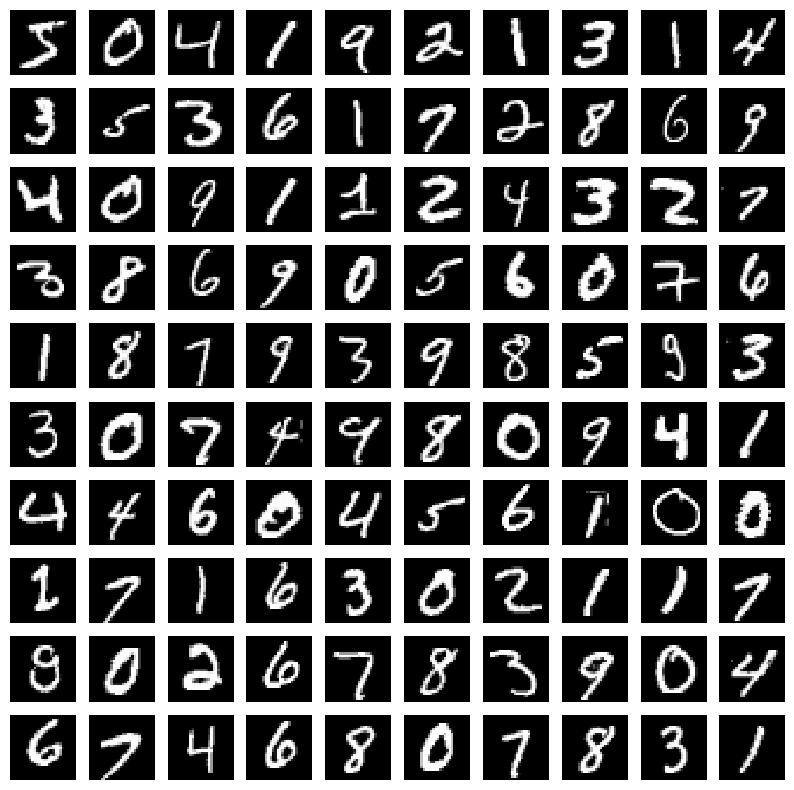

In [33]:
plt.figure(figsize=[10,10])
for i in range(0,100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(train_dataset[i][0], (28,28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [27]:
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices

if args.train_proportion == 1.0:
  # we use all train dataset without partitioning
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
  val_loader = test_loader
else:
  # partition dataset according to train_proportion
  train_indices, val_indices = partition_dataset(len(train_dataset), args.train_proportion)
  # create data loaders for train, validation and test datasets
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
  val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)


## Train Model

In [35]:
# Model Initialization
gmvae = GMVAE(args)

In [36]:
# Training Phase
history_loss = gmvae.train(train_loader, val_loader)

(Epoch 1 / 100) Train_Loss: 188.862; Val_Loss: 159.133   Train_ACC: 28.747; Val_ACC: 43.890   Train_NMI: 18.782; Val_NMI: 41.893 Train_ARI: 11.855; Val_ARI: 30.084
(Epoch 2 / 100) Train_Loss: 147.335; Val_Loss: 137.211   Train_ACC: 48.390; Val_ACC: 53.210   Train_NMI: 43.308; Val_NMI: 47.605 Train_ARI: 31.888; Val_ARI: 36.539
(Epoch 3 / 100) Train_Loss: 134.321; Val_Loss: 130.175   Train_ACC: 54.875; Val_ACC: 55.990   Train_NMI: 47.495; Val_NMI: 48.564 Train_ARI: 37.659; Val_ARI: 37.797
(Epoch 4 / 100) Train_Loss: 129.458; Val_Loss: 127.128   Train_ACC: 57.990; Val_ACC: 58.530   Train_NMI: 50.045; Val_NMI: 51.732 Train_ARI: 40.862; Val_ARI: 41.952
(Epoch 5 / 100) Train_Loss: 126.385; Val_Loss: 124.506   Train_ACC: 59.615; Val_ACC: 60.210   Train_NMI: 52.070; Val_NMI: 53.430 Train_ARI: 43.358; Val_ARI: 44.520
(Epoch 6 / 100) Train_Loss: 124.250; Val_Loss: 122.657   Train_ACC: 60.443; Val_ACC: 61.430   Train_NMI: 53.525; Val_NMI: 54.783 Train_ARI: 45.053; Val_ARI: 45.883
(Epoch 7 / 100) 

In [31]:
import os
# Create folder if not exists
os.makedirs("fig", exist_ok=True)
plt.style.use('seaborn-v0_8-whitegrid')

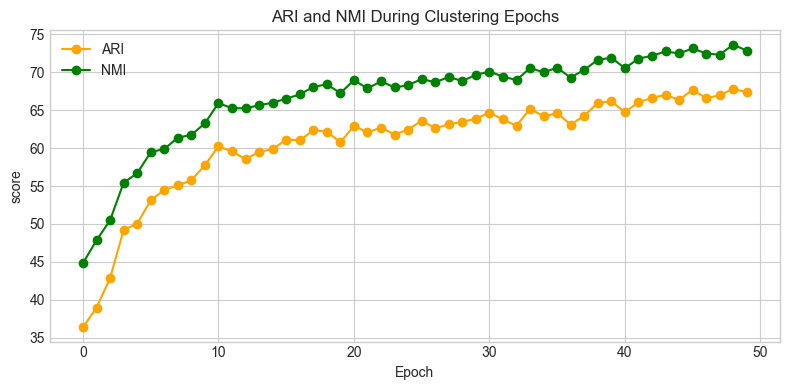

In [32]:
# Plot Rec-Loss during Pretraining
plt.figure(figsize=(8, 4))
plt.plot(history_loss['val_history_ari'], marker='o', label="ARI", color='orange')
plt.plot(history_loss['val_history_nmi'], marker='o', label="NMI", color='green')
plt.title("ARI and NMI During Clustering Epochs")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("score")
plt.grid(True)
plt.tight_layout()
plt.show()

## Test Data

In [30]:
accuracy, nmi, ari = gmvae.test(test_loader)

print("Testing phase...")
print("Accuracy: %.5lf,  NMI: %.5lf, ARI: %.5lf" % (accuracy, nmi, ari) )

Testing phase...
Accuracy: 71.67000,  NMI: 70.93452, ARI: 60.89568


In [34]:
torch.save(gmvae.network.state_dict(), 'gmvae_50_epochs_model.pth')

In [6]:
model = GMVAE(args)  # must initialize the model with same args structure
model.network.load_state_dict(torch.load('gmvae_50_epochs_model.pth', map_location='cpu'))
model.network.eval()

GMVAENet(
  (inference): InferenceNet(
    (inference_qyx): ModuleList(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): GumbelSoftmax(
        (logits): Linear(in_features=512, out_features=10, bias=True)
      )
    )
    (inference_qzyx): ModuleList(
      (0): Linear(in_features=794, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Gaussian(
        (mu): Linear(in_features=512, out_features=64, bias=True)
        (var): Linear(in_features=512, out_features=64, bias=True)
      )
    )
  )
  (generative): GenerativeNet(
    (y_mu): Linear(in_features=10, out_features=64, bias=True)
    (y_var): Linear(in_features=10, out_features=64, bias=True)
    (generative_pxz): ModuleList(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): ReLU()
      (2): 

In [40]:
accuracy_, nmi_, ari_ = model.test(test_loader)

print("Testing phase...")
print("Accuracy: %.5lf,  NMI: %.5lf, ARI: %.5lf" % (accuracy_, nmi_, ari_) )

Testing phase...
Accuracy: 78.28000,  NMI: 72.83578, ARI: 67.34196


## Image Reconstruction

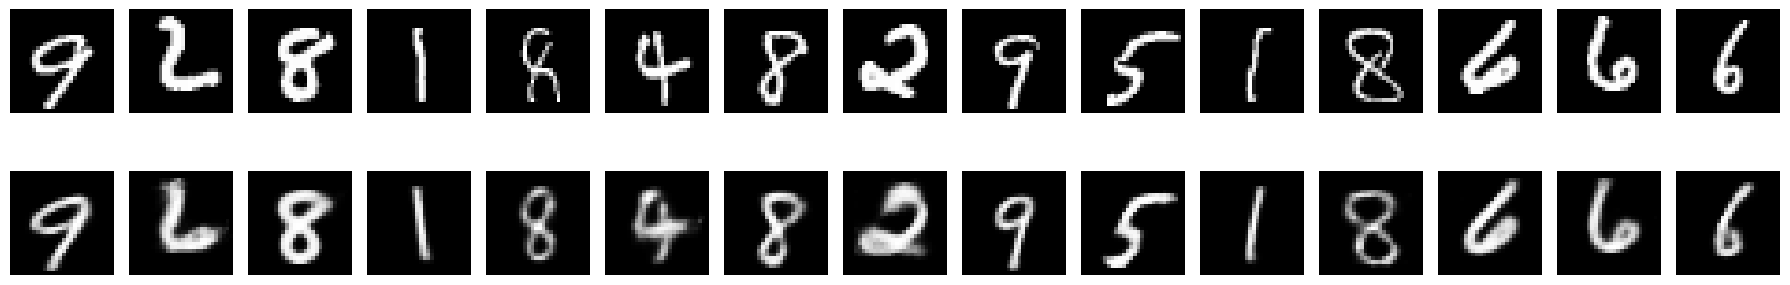

In [9]:
def display_reconstructed(original, reconstructed, n=10):
    plt.figure(figsize=[18, 4])
    for i in range(n):
        # Original image
        plt.subplot(2, n, i + 1)
        img = original[i]
        if isinstance(img, torch.Tensor):
            img = img.cpu().detach().numpy()
        if img.ndim == 1:
            img = img.reshape(28, 28)
        elif img.ndim == 3:
            img = img.squeeze(0)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, n, i + 1 + n)
        img = reconstructed[i]
        if isinstance(img, torch.Tensor):
            img = img.cpu().detach().numpy()
        if img.ndim == 1:
            img = img.reshape(28, 28)
        elif img.ndim == 3:
            img = img.squeeze(0)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
original, reconstructed = model.reconstruct_data(test_loader, 15)
display_reconstructed(original, reconstructed, 15)

## Random Generation per Category

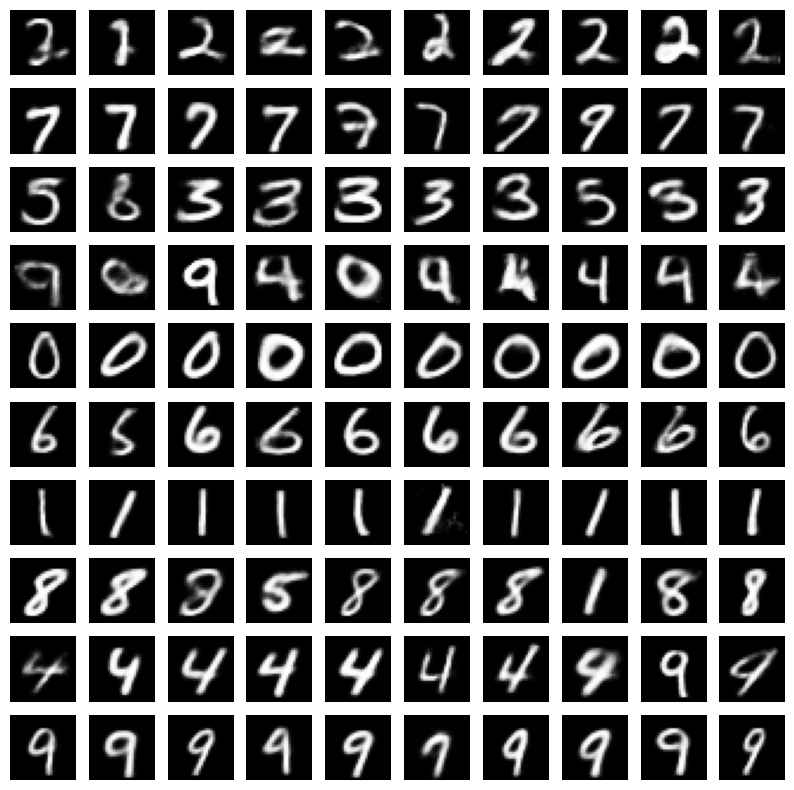

In [25]:
def display_random_generation(generated, num_classes, n=10):
  plt.figure(figsize=[10,10])
  for c in range(num_classes):
    for i in range(n):
      plt.subplot(num_classes, n, (c * n) + i + 1)
      plt.imshow(generated[(c * n) + i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

elem_per_category = 10
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

## Visualization of the feature latent space

In [26]:
# get feature representations
test_features, test_labels = gmvae.latent_features(test_loader, True)

In [27]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm
tsne_features = TSNE(n_components=2).fit_transform(test_features[:1000,])

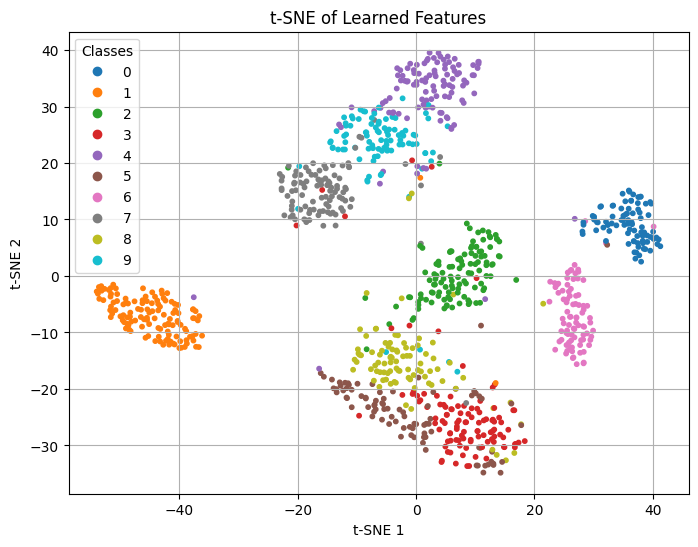

In [30]:
# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE of Learned Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()